# Getting Started

This guide will make use of the dataset generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model.
The dataset consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine - i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation are considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data are contaminated with sensor noise.

The engine is operating normally at the start of each time series and starts to degrade at some point during the series. In the training set, the degradation grows in magnitude until a predefined threshold is reached beyond which it is not preferable to operate the engine. In the test set, the time series ends some time prior to complete degradation. The objective of the competition is to predict the number of operational cycles after the last cycle that the engine will continue to operate properly.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle; each column is a different variable.

Dataset structure

* Unit: Engine number [-]
* t: time [cycles]
* 0p1: operational setting 1
* op2: operational setting 2
* op3: operational setting 3
* s1: Sensor measurement 1
* s2: Sensor measurement 2
...
* s20: sensor measurement 20


In the first set of data, there are 100 train trajectories and 100 test trajectories.



[1] A. Saxena, M. Ieee, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Prognostics,” Response, 2008. 

## Import

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


sns.set()




# Dataset

In [2]:
from ceruleo.dataset.catalog.CMAPSS import CMAPSSDataset

train_dataset = CMAPSSDataset(train=True, models='FD001')
validation_dataset = CMAPSSDataset(train=False, models='FD001')

2022-08-02 23:51:37.267536: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Number of lives in the training set

In [3]:
len(train_dataset)

100

### Number of lives in the validation set

In [4]:
len(validation_dataset)

100

## Visualization

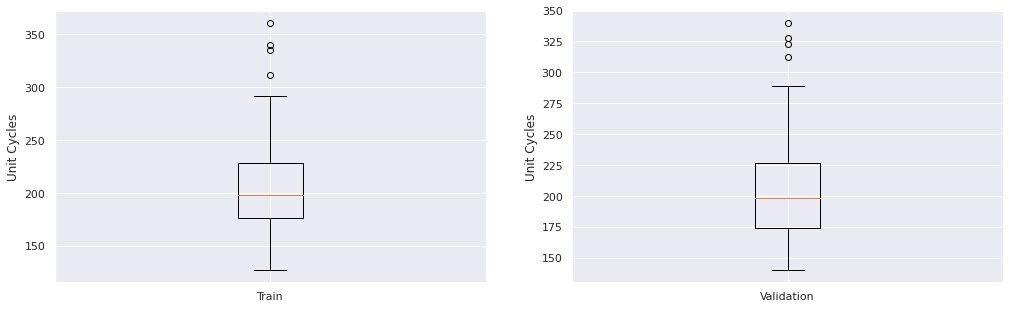

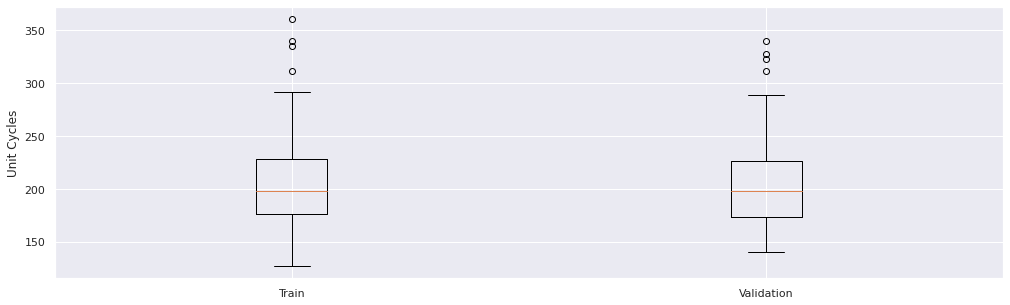

In [5]:
from ceruleo.graphics.duration import durations_boxplot

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
durations_boxplot(train_dataset, 
                  xlabel='Train', 
                  ylabel='Unit Cycles', 
                  ax=ax[0])
durations_boxplot(validation_dataset, 
                  xlabel='Validation', 
                  ylabel='Unit Cycles', 
                  ax=ax[1]);

ax = durations_boxplot([train_dataset, validation_dataset], 
                  xlabel=['Train', 'Validation'], 
                  ylabel='Unit Cycles',
                  figsize=(17, 5))

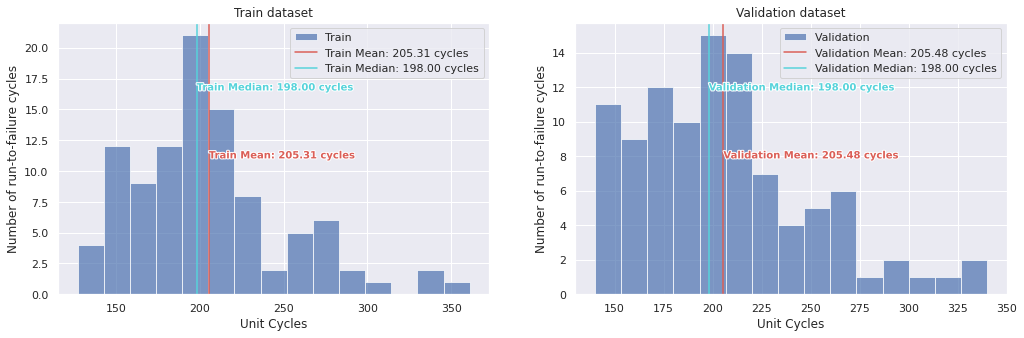

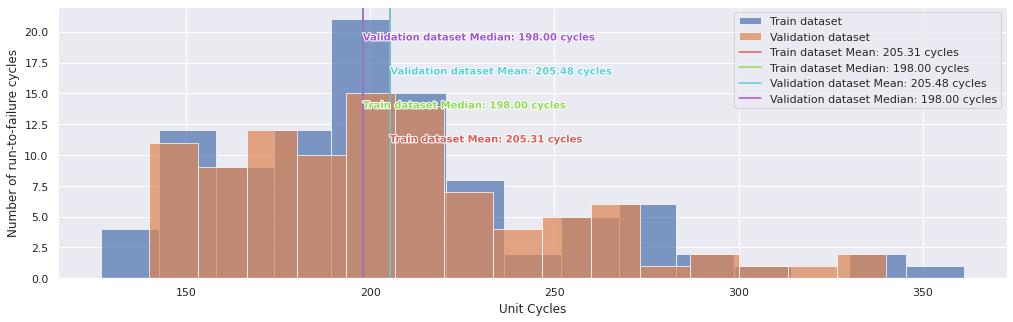

In [6]:
from ceruleo.graphics.duration import lives_duration_histogram

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
lives_duration_histogram(train_dataset, 
                         label='Train',
                         xlabel='Unit Cycles', 
                         units='cycles',
                         alpha=0.7,
                         ax=ax[0])
ax[0].set_title('Train dataset')
lives_duration_histogram(validation_dataset, 
                         label='Validation',
                         xlabel='Unit Cycles', 
                         units='cycles',
                         alpha=0.7,
                         ax=ax[1])
ax[1].set_title('Validation dataset');

lives_duration_histogram([train_dataset,validation_dataset], 
                         label=['Train dataset','Validation dataset'],
                         xlabel='Unit Cycles', 
                         alpha=0.7,
                         units='cycles',
                         figsize=(17, 5));

## Transformers

There are two ways of defining a transformer. The first way is more similar to the scikit-learn Pipeline API, and the other one is similar to the tensorflow functional API.
Two pipelines have to be defined:
* How the data is going to be transformed
    * This transformer invovles selecting and transforming and generating features
* How the target is going to be transformed
    * This transformer involves selecting and transforming the target

The base class of the pipeline is the `LivesPipeline` class. This class is an extension of `sklearn.pipeline.Pipeline` and change the way the data is fitted. 
Each transformer class inherit from the `TransformerStep`. This class implements the method `partial_fit` which receives the data belonging to the whole life and update its internal state accordingly.

### Functional API

Following the literature, the future that addresses this dataset, only a subset of the feature are going to be used to fit our model.

In [3]:
from ceruleo.dataset.catalog.CMAPSS import sensor_indices
features = [train_dataset[0].columns[i] for i in sensor_indices]
features

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

The transformation of the input data will be simple, a feature scaling between -1 and 1 and imputing any missing value or non finite.

In [11]:
from ceruleo.transformation.features.selection import ByNameFeatureSelector
from ceruleo.transformation.features.scalers import MinMaxScaler
from ceruleo.transformation.features.imputers import MeanImputer

functional_pipe = ByNameFeatureSelector(features=features)
functional_pipe = MinMaxScaler(range=(-1,1))(functional_pipe)
functional_pipe = MeanImputer()(functional_pipe)

One common approach for handling PM problems is to downplay the early stages of the execution due to the fact that that is harder to detect indication of degradation at the beggining.

For this dataset, a piece-wise linear degradation model has been validated to be suitable and effective. In general, the engine unit works normally in the early age and degrades linearly afterwards. It is assumed to have a constant RUL label in the initial period.  [1]

[1] Li, X., Ding, Q., & Sun, J. Q. (2018). Remaining useful life estimation in prognostics using deep convolution neural networks. Reliability Engineering & System Safety, 172, 1-11.

In [15]:
from ceruleo.transformation.target import PicewiseRUL

target_pipe = ByNameFeatureSelector(features=['RUL'])
target_pipe = PicewiseRUL(max_life=125)(target_pipe)

In [17]:
from ceruleo.transformation.functional.transformers import Transformer
functional_transformer = Transformer(
    transformerX=functional_pipe,
    transformerY=target_pipe)


### Fitting the transformer

The transformer must be fitted on the dataset.

In [18]:
functional_transformer.fit(train_dataset)

### Transforming a life

In [19]:
X, y, m = functional_transformer.transform(train_dataset[0])

In [20]:
X.shape

(192, 14)

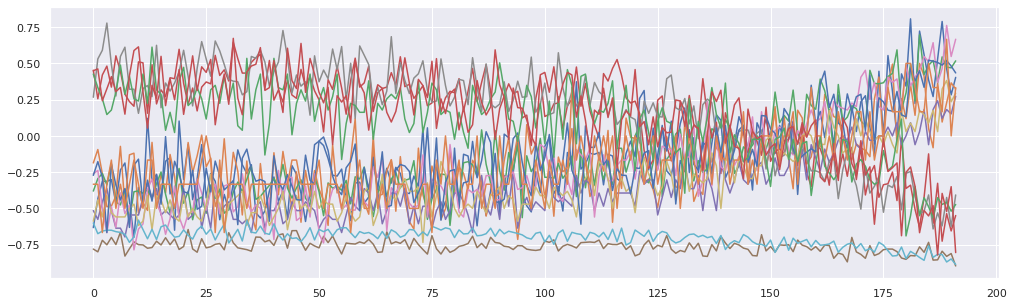

In [23]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

## Iterators

### Lives iterator

The dataset can be iterated. Each element of the iteration is life in stored in `pd.DataFrame` which contains all the features

In [24]:
train_dataset[0].columns

Index(['Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1',
       'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
       'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
       'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
       'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21', 'RUL',
       'OpMode', 'Engine'],
      dtype='object')

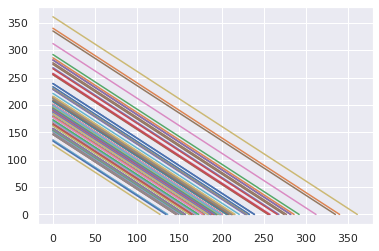

In [25]:
fig, ax = plt.subplots()
for life in train_dataset:
    ax.plot(life['RUL'].values)

### WindowedDatasetIterator
The windowed dataset iterator provides a way of iterating the transformed dataset trough an sliding window. The sample for the i-th element, provides the (window-1) elements of the window. It also provides capabilities to shuffle in diverse ways the how the samples are delivered by the iterator.

In [26]:
window = 7
iterator = WindowedDatasetIterator(
    train_dataset,
    window,
    functional_transformer,
    step=1,
    output_size=1,
    shuffle=False)

X, y, sw= next(iterator)

NameError: name 'WindowedDatasetIterator' is not defined

Since we are using the functional_transformer that only has 14 feature and a window size of 7 samples. The output of one element of the iterator wil be a matrix ox size (7 x14)

In [29]:
X.shape

(7, 14)

## Batcher

The batcher class make use of the `WindowedDatasetIterator` to generate batches of samples.

In [30]:
window = 25
batch_size = 66
step = 2
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False)
X, y, sw = next(train_batcher)

As expected the shape of the input data of one batch is:
* 66 due to the batch size
* 25 because the lookback window size
* 14 for the selected features in the transformer

In [31]:
X.shape

(66, 25, 14)

In [32]:
y.shape

(66, 1, 1)

### How dos a sample looks like?

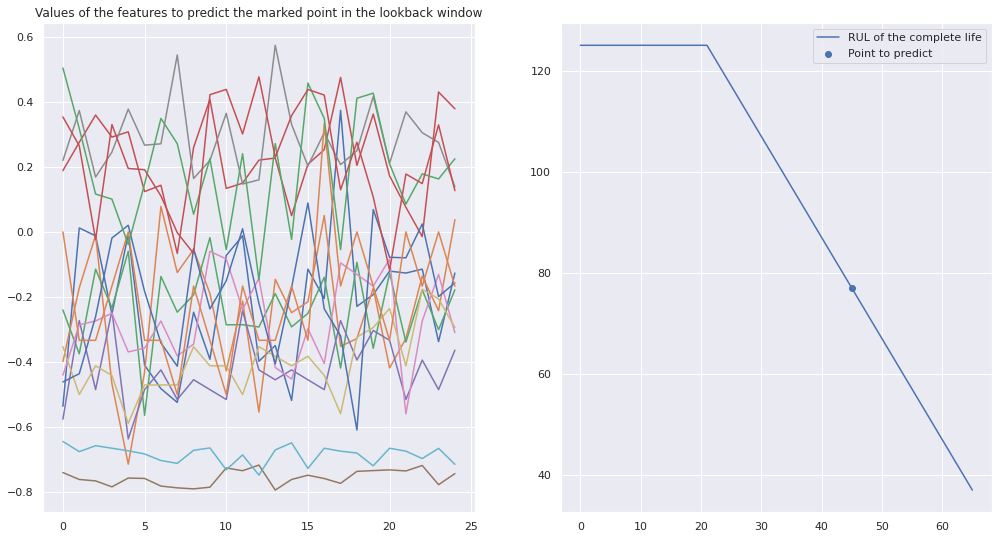

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[45, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(np.squeeze(y), label='RUL of the complete life')
ax[1].scatter(x=45, y=y[45], label='Point to predict')
ax[1].legend()

## Model

### Keras models

Let's create a simple model in keras with some FC layers. 


First of all we need to create two batchers for feeding the model.

In [34]:
step = 1
batch_size = 16
window = 64
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)



A simple fully connected model is already implemented in the library. You can specify the number of layers and the hidden dimension

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5)
model = FCN([512, 256],
            dropout=0.5,
            learning_rate=0.0001,
            loss='mse',
            batch_normalization=False,
            l2=None)

r = model.fit(train_batcher, val_batcher , epochs=25, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               459264    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 590,849
Trainable params: 590,849
Non-trainable params: 0
__________________________________________________

### Saving the model

In [38]:
model.save('FC_example')

INFO:tensorflow:Assets written to: /home/luciano/fuentes/lru_gcd/doc/examples/FC_example/assets


#### Loading the model

In [39]:
model = FCN.load('FC_example')

#### Learning curves

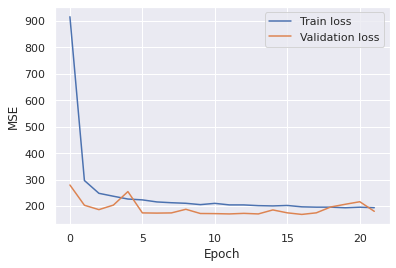

In [40]:
fig, ax = plt.subplots()
ax.plot(r['loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

#### Prediction on the training set

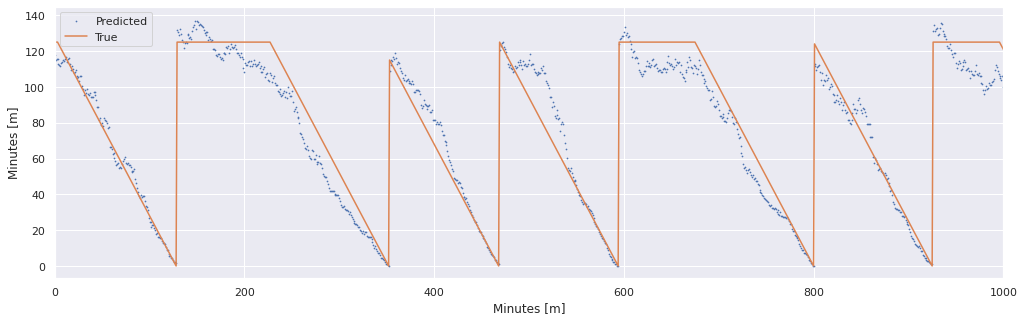

In [41]:
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            1, 
                            cache_size=500,
                            shuffle=False,
                            restart_at_end=False)

y_pred = model.predict(train_batcher)
y_true = true_values(train_batcher.iterator)

temp_result = {
    'FCN':[
            {
                'true': y_true,
                'predicted': y_pred
        }
    ]
}

ax = plot_true_and_predicted(
    temp_result,
    units='Minutes [m]',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

#### Prediction on the validation set

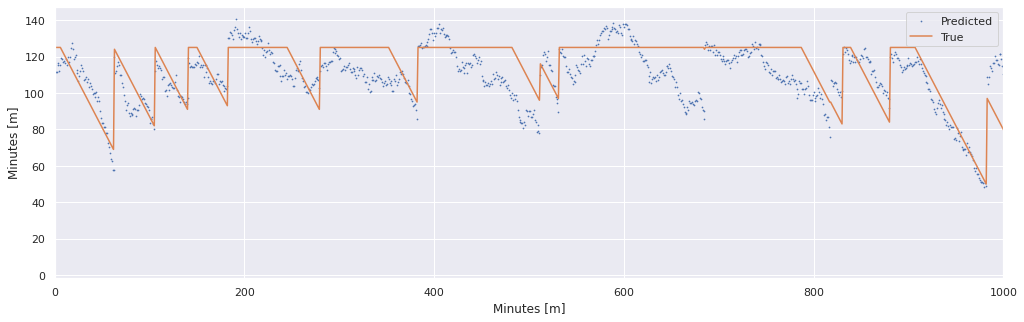

In [42]:

y_pred_fcn = model.predict(val_batcher)
y_true_fcn = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'FCN': [
            {
                'true': y_true_fcn,
                'predicted': y_pred_fcn
            }
        ]
    },
    units='Minutes [m]',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

Instead of having an array with all the predictions, another possibility to handling the predictions is using the `FittedLife class`. The function `split_lives` splits the whole set of predictions into a list of `FittedLife` objects. This class will also fit a picewise linear approximation of the predictions.

In [59]:
lives = split_lives(y_true_fcn, y_pred_fcn, RUL_threshold=125, fit_line_not_increasing=True)

In [60]:
lives[0:3]

We can plot one independent life and show also a RLS fitted from the predicted points

<AxesSubplot:xlabel='Unit Cycles', ylabel='Unit Cycles'>

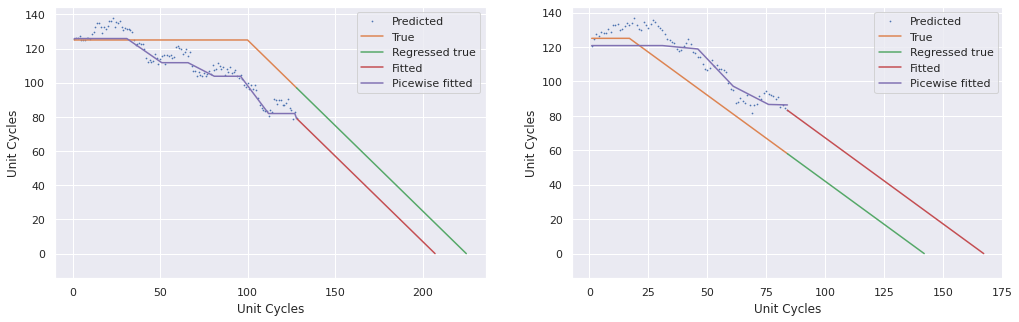

In [61]:
life1 = 6
life2 = 15
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Unit Cycles', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Unit Cycles', add_fitted=True, ax=ax[1])

From each of the lives we cam compute diverse metrics:
* MAE
* RMSE
* Unexploited lifetime [1]
* Unexpected breaks [1]

[1] Machine Learning for Predictive Maintenance: A Multiple Classifiers Approach
    Susto, G. A., Schirru, A., Pampuri, S., McLoone, S., & Beghi, A. (2015). 

In [46]:

pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime [m]': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

,MAE,RMSE,Unexpected Break,Unexploited lifetime [m]
Life 1,13.468262,15.885864,False,17.85125
Life 2,15.393592,16.968799,True,0.00000


## A more complex model

We can use the model defined in the article "Remaining useful life estimation in prognostics using deep convolution neural networks" by Xiang Lia, Qian Ding and Jian-Qiao Sun already defined in the library.

In [47]:
from tensorflow.keras.callbacks import LearningRateScheduler

from rul_pm.models.keras.losses import root_mean_squared_error

step = 1
batch_size = 128
window = 30
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)

def scheduler(epoch, lr):
    """Learning rate as reported in the article"""
    if epoch < 17:
        return 0.001
    else:
        return 0.0001


model = XiangQiangJianQiaoModel(n_filters=10,
                                filter_size=10,
                                dropout=0.5,
                                loss=root_mean_squared_error, 
                                learning_rate=0.001)
r = model.fit(train_batcher, val_batcher , epochs=25, callbacks=[LearningRateScheduler(scheduler, verbose=True)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 30, 14, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 14, 10)        110       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 14, 1)         31    

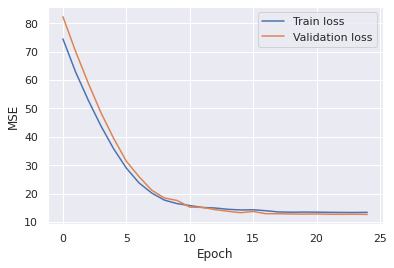

In [48]:
fig, ax = plt.subplots()
ax.plot(r['loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

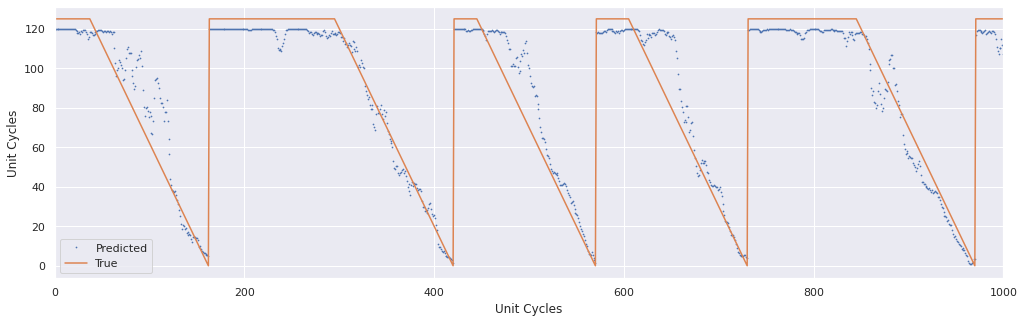

In [49]:
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500)
y_pred = model.predict(train_batcher)
y_true = true_values(train_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'XiangQiangJianQiaoModel': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Unit Cycles',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

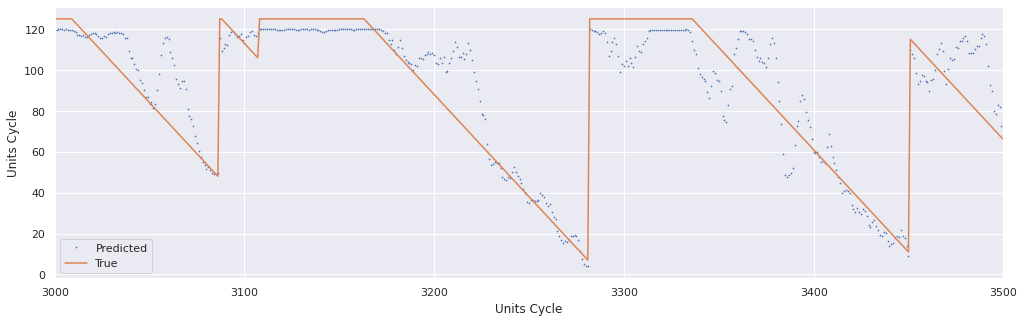

In [50]:

y_pred_XQJQ = model.predict(val_batcher)
y_true_XQJQ = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'XiangQiangJianQiaoModel': [
            {
                'true': y_true_XQJQ,
                'predicted': y_pred_XQJQ
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);

In [62]:
lives = split_lives(y_true_XQJQ, y_pred_XQJQ, RUL_threshold=125, fit_line_not_increasing=True)

<AxesSubplot:xlabel='Units Cycle', ylabel='Units Cycle'>

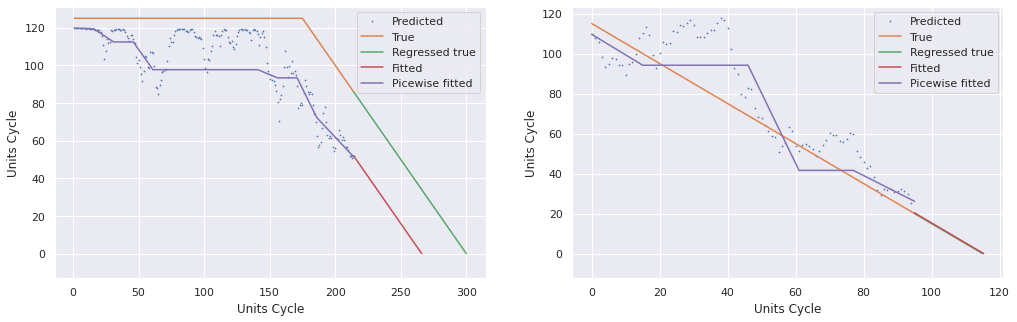

In [63]:
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])

In [64]:

pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,19.920854,24.402116,False,34.016132
Life 2,12.416699,15.975119,True,0.000000


## A custom model
Also the library allows the creation of custom Keras and Pytorch models. 


In [54]:
from rul_pm.models.keras.keras import KerasTrainableModel
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv1D, Flatten, Dense)


class CustomModel(KerasTrainableModel):
    def build_model(self, input_shape):
        x = Input(input_shape)
        input = x
        x = Conv1D(10, 15, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(1, activation='relu')(x)
        return Model(inputs=[input], outputs=[x])
    

In [66]:
step = 1
batch_size = 128
window = 30
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)


In [67]:


from rul_pm.models.keras.losses import root_mean_squared_error





model = CustomModel(loss=root_mean_squared_error, 
                     learning_rate=0.001)
r = model.fit(train_batcher, val_batcher , epochs=25)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 16, 10)            2110      
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 2,271
Trainable params: 2,271
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
139/139 [==============================] - 3s 16ms/step - loss: 72.2865 - root_mean_squared_error: 63.4185 - val_loss: 23.5960 - val_root_mean_squared_error: 21.0650
Epoch 2/25
139/139 [==============================] - 1s 7ms/step - loss: 24.179

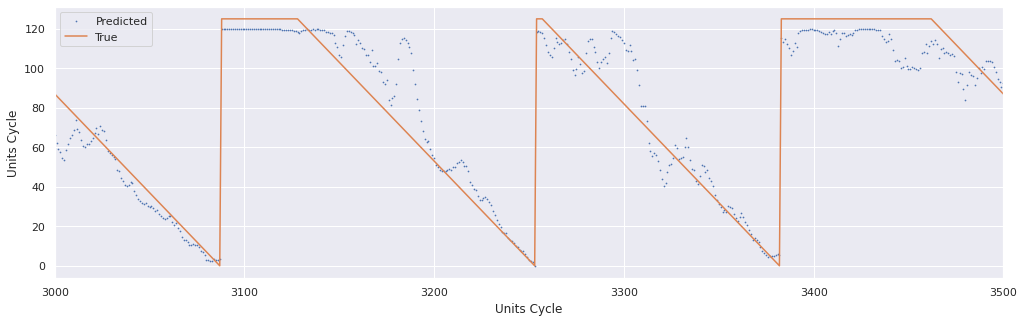

In [70]:

y_pred_custom = model.predict(val_batcher)
y_true_custom = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'CustomModel': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,25.282678,27.670572,False,26.437256
Life 2,13.020645,14.412559,True,0.000000


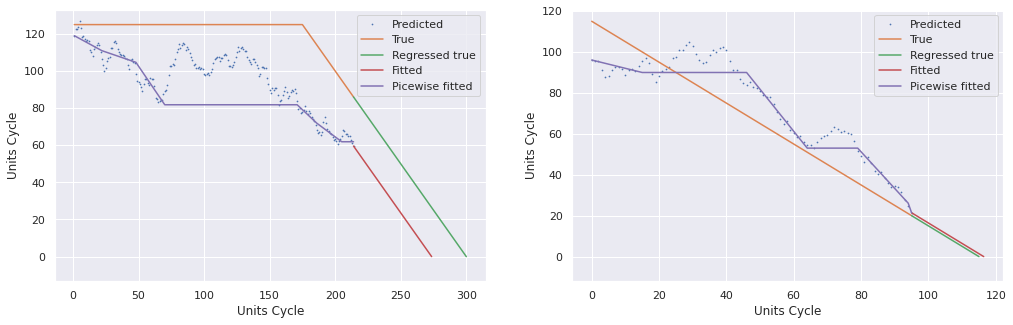

In [73]:

lives = split_lives(y_true_custom, y_pred_custom, RUL_threshold=125, fit_line_not_increasing=True)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

### Scikit-learn and gradient boosting models
Following the same API we can create scikit-learn and XGBoost models for regressing our data.

##### Scikit-learn model
In the following example we are going to create a RandomForestRegressor to predict the RUL of the same dataset

In [74]:
from sklearn.ensemble import RandomForestRegressor



step = 1
window = 30
train_iterator = WindowedDatasetIterator(train_dataset,  
                            window, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_iterator = WindowedDatasetIterator(validation_dataset,  
                            window, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500)


model = SKLearnModel(RandomForestRegressor())
model.fit(train_iterator)

In [75]:
y_pred_rf = model.predict(val_iterator)
y_true_rf = true_values(val_iterator)

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,34.644439,36.862445,False,40.34
Life 2,10.021458,12.246251,True,0.00


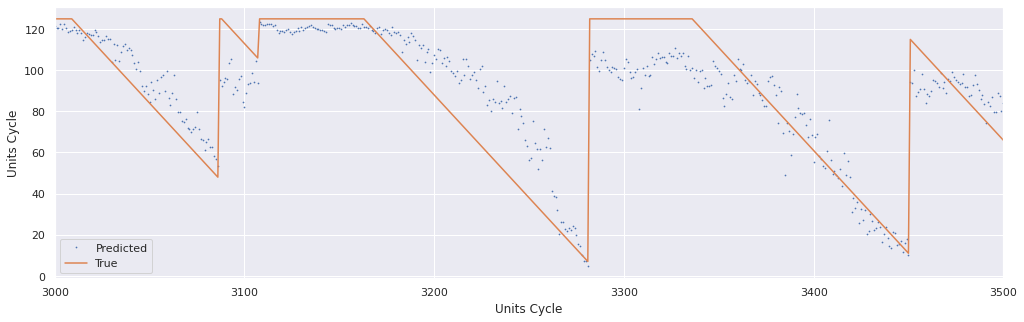

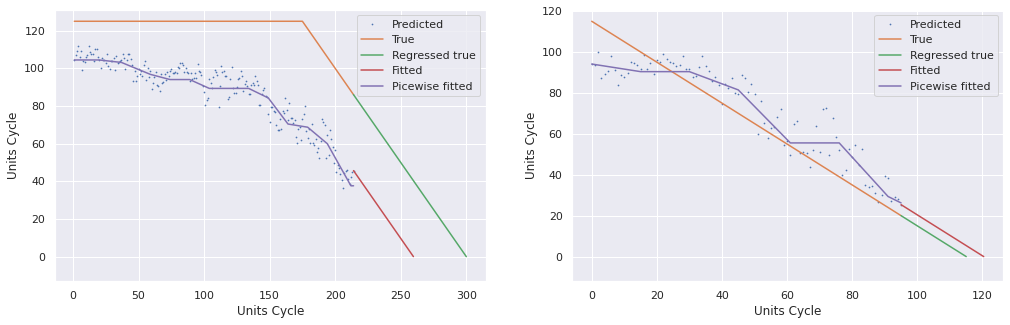

In [76]:
ax = plot_true_and_predicted(
    {
        'RandomForest': [
            {
                'true': y_true_rf,
                'predicted': y_pred_rf
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);
lives = split_lives(y_true_rf, y_pred_rf, RUL_threshold=125, fit_line_not_increasing=True)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

##### Gradient boosting model

In [77]:
from rul_pm.models.gradientboosting import XGBoostModel
model = XGBoostModel()
model.fit(train_iterator)

In [78]:
y_pred_gb = model.predict(val_iterator)
y_true_gb = true_values(val_iterator)

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,26.788751,31.534081,False,45.116096
Life 2,15.216826,18.304058,True,0.000000


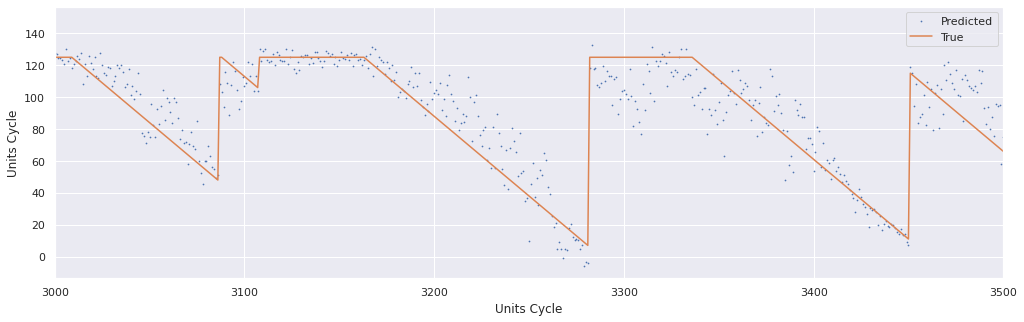

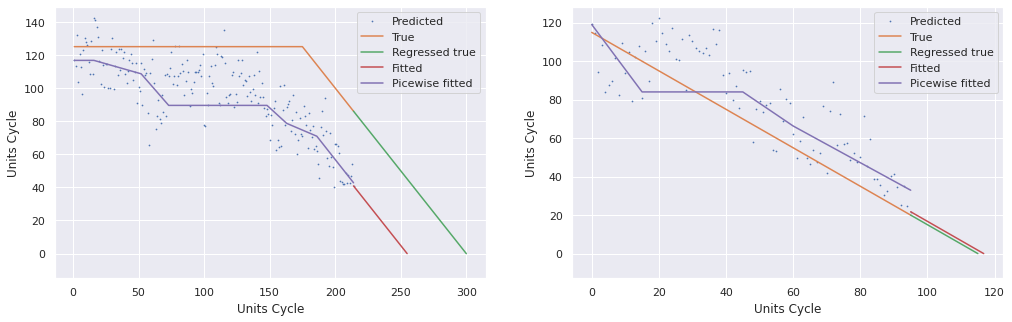

In [79]:
ax = plot_true_and_predicted(
    {
        'Gradient Boosting': [
            {
                'true': y_true_gb,
                'predicted': y_pred_gb
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);
lives = split_lives(y_true_gb, y_pred_gb, RUL_threshold=125, fit_line_not_increasing=True)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

## Model comparison and evaluation

One of the most important issues regarding PM is the ability to compare and evaluate different methods.

The main data structure used in the results module is a dictionary in which each of the keys is the model name, and the elements are a list of dictionaries. Each of the dictionaries contains two keys: true, predicted. 
Each element of the model array is interpreted as a Fold in CV settings. If the array contains only one element it can be considered that the evaluation has been made on a hold-out set.

For this poropouse there are function for visualizing the results on a hold-out set:

- `hold_out_barplot_errors_wrt_RUL_multiple_models`
- `hold_out_boxplot_errors_wrt_RUL_multiple_models`

And for visualizing the reults on a cross validated predictions:

- `cv_barplot_errors_wrt_RUL_multiple_models`
- `cv_boxplot_errors_wrt_RUL_multiple_models`




This in an example of the dictionary structure

```python
    {
        'Model Name': [
            {
                'true': [true_0, true_1,...., true_n],
                'predicted': [pred_0, pred_1,...., pred_n]
            },
            {
                'true': [true_0, true_1,...., true_m],
                'predicted': [pred_0, pred_1,...., pred_m]
            },
            ...
        'Model Name 2': [
             {
                'true': [true_0, true_1,...., true_n],
                'predicted': [pred_0, pred_1,...., pred_n]
            },
            {
                'true': [true_0, true_1,...., true_m],
                'predicted': [pred_0, pred_1,...., pred_m]
            },
            ...
        ]
    }
```


The first step is to construct our data structure. Since we evaluated in a hold-out set, each list of each model will contain only one element.

In [112]:
results = {
    'FCN': [
        {
            'true': y_true_fcn,
            'predicted': y_pred_fcn
        }
    ],
    'XiangQiangJianQiao': [
        {
            'true': y_true_XQJQ,
            'predicted': y_pred_XQJQ
        }
    ],
    'Custom': [
        {
            'true': y_true_custom,
            'predicted': y_pred_custom
        }
    ],
    'Gradient Boosting': [
        {
            'true': y_true_gb,
            'predicted': y_pred_gb,
        }
    ],
    'Random forest': [
        {
            'true': y_true_rf,
            'predicted': y_pred_rf
        }
    ]
}

### Bar Plot

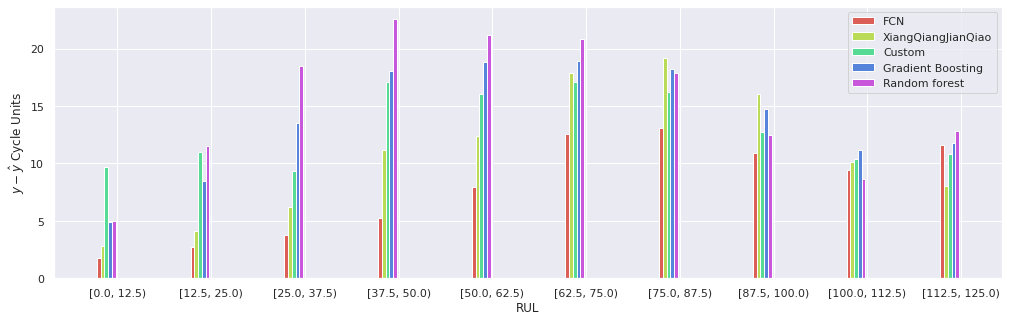

In [113]:
hold_out_barplot_errors_wrt_RUL_multiple_models(results, 10, figsize=(17, 5), y_axis_label=' Cycle Units');

### Box Plot

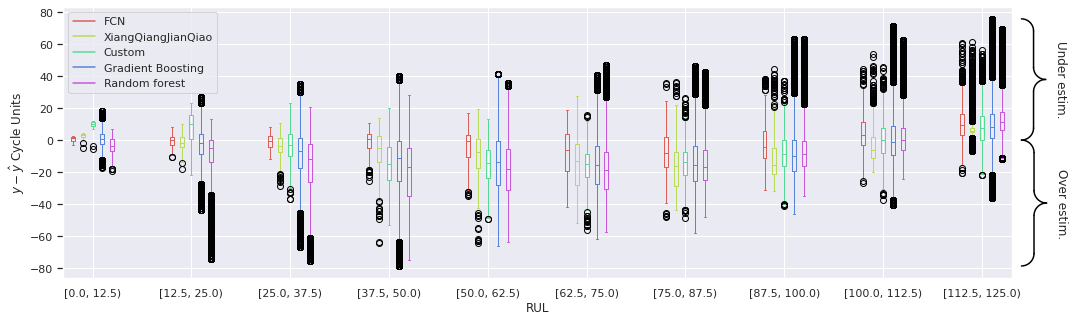

In [114]:
hold_out_boxplot_errors_wrt_RUL_multiple_models(results, 10, figsize=(17, 5), y_axis_label=' Cycle Units');

### 
Additionally to the regression error, it is possible to compute some metrics more easily interpretable. In this context, two metrics were defined in [1], namely:

- Frequency of Unexpected Breaks (ρUB) - the percentage of failures not prevented;
- Amount of Unexploited Lifetime (ρUL) - the average number of time that could have been run before failure if the preventative maintenance suggested by the maintenance management mod-ule had not been performed.

A comparison between the predicted end of life with respect to the true end of that particular life is made. 

In that case, three scenarios can happen:
- The predicted end of life occurs before the true one. In that case, the predictions were pessimistic and the tool could have been used more time.
- The remaining useful life arrives at zero after the true remaining useful life. In that case, we incur the risk of the tool breaking.  
- The predicted line coincides with the true line. In that case, we don’t have unexploited time, and the risk of breakage can be considered 0.


Since usually the breakages are considered more harmful, a possible approach to preventing unexpected failures is to consider a more conservative maintenance approach, providing maintenance tasks recommendations some time before the end of life predicted. In that way, a conservative window can be defined in which the recommendation of making maintenance task should be performed at time T-predicted - conservative window size.

It is possible to visualize how it grows the unexploited lifetime grows as the conservative window size grows and how the unexpected breaks decrease as the conservative window size grows.





[1] Machine Learning for Predictive Maintenance: A Multiple Classifiers Approach
    Susto, G. A., Schirru, A., Pampuri, S., McLoone, S., & Beghi, A. (2015). 

<AxesSubplot:title={'center':'Unexpected breaks'}, xlabel='Fault window size [Cycle units]', ylabel='Risk of breakage'>

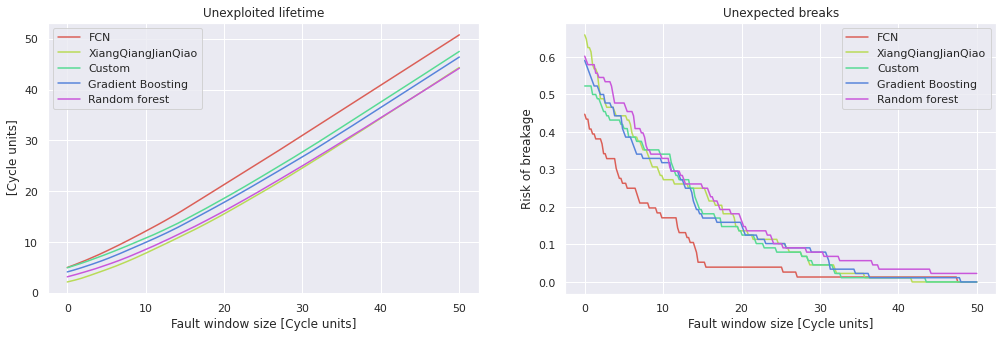

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_unexploited_lifetime(results, max_window=50, n=250, ax=ax[0], units=' [Cycle units]')
plot_unexpected_breaks(results, max_window=50, n=250, ax=ax[1], units=' [Cycle units]')

### Comparison with baseline models
Another important issue to consider when comparing models is to evaluate the models with respect to preventive maintenance approaches. RUL-PM provides `BaselineModel` that computes the mean and the median duration from the true targets of the data. `BaselineModel` uses a `LifeDatasetIterator`, that as its names indicate, iterate over each life, transforming it.

#### Baseline models creation

In [92]:
mean_baseline_model = BaselineModel(mode='mean', RUL_threshold=125)
median_baseline_model = BaselineModel(mode='median', RUL_threshold=125)

#### Fitting baseline models

In [126]:
life_iterator = LifeDatasetIterator(train_dataset, functional_transformer)

mean_baseline_model.fit(life_iterator)
median_baseline_model.fit(life_iterator)

In [127]:
life_iterator = LifeDatasetIterator(validation_dataset, functional_transformer)
y_pred_mean = mean_baseline_model.predict(life_iterator)
y_true_mean = true_values(life_iterator)


y_pred_median = median_baseline_model.predict(life_iterator)
y_true_median = true_values(life_iterator)

In [128]:
results_baseline = {
    'Mean baseline': [
        {
            'true': y_true_mean,
            'predicted': y_pred_mean
        }
    ],
    'Median baseline': [
        {
            'true': y_true_median,
            'predicted': y_pred_median
        }
    ]
}

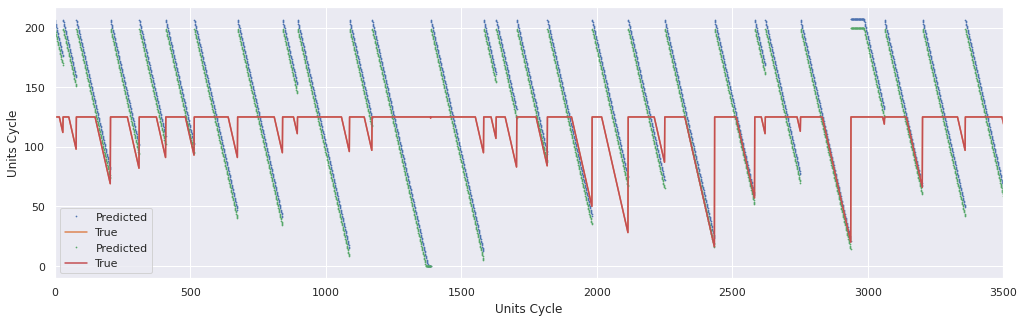

In [129]:
ax = plot_true_and_predicted(
    results_baseline,
    units='Units Cycle',
    figsize=(17, 5))
ax.set_xlim(0, 3500);


,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,36.644295,38.675209,True,0.0
Life 2,19.477157,27.340957,False,9.0


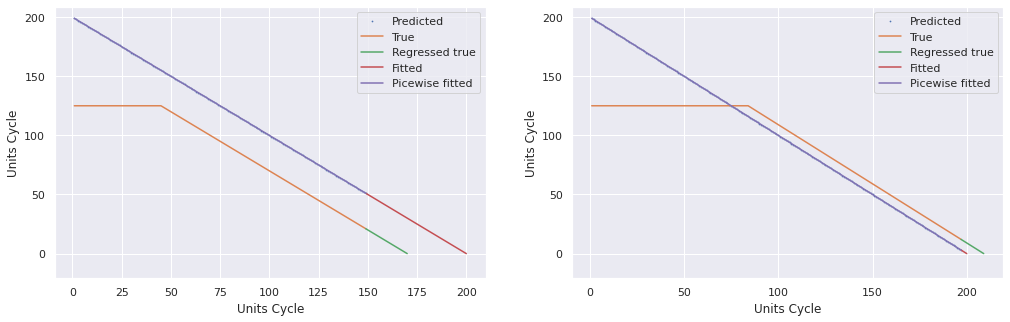

In [130]:

lives = split_lives(y_true_median, y_pred_median, RUL_threshold=125)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

### Comparison with the full set of models

#### Regression metrics

In [147]:
pd.DataFrame(cv_regression_metrics(results)).T[['mean']]

,mean
FCN,10.344598
XiangQiangJianQiao,10.070873
Custom,11.980034
Gradient Boosting,12.825324
Random forest,13.698453
Mean baseline,41.795912
Median baseline,38.356063


#### Maintenance metrics

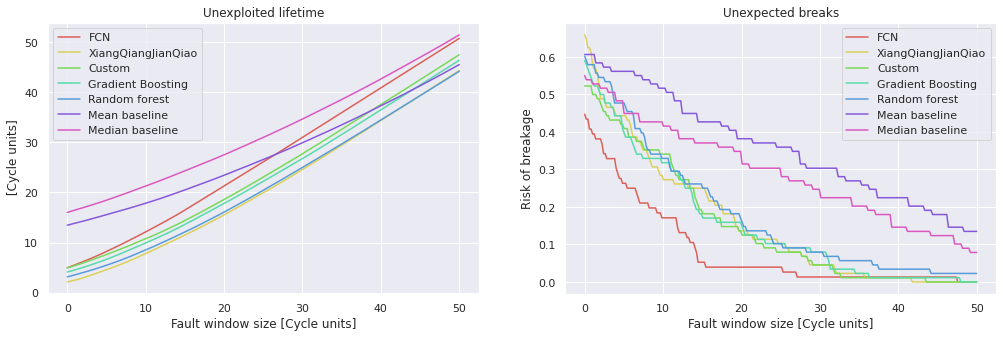

In [149]:
results.update(results_baseline)

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_unexploited_lifetime(results, max_window=50, n=250, ax=ax[0], units=' [Cycle units]')
plot_unexpected_breaks(results, max_window=50, n=250, ax=ax[1], units=' [Cycle units]');